In [1]:
import os
import gc
import random
from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn import model_selection, metrics

import cv2
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    ShiftScaleRotate, Transpose
    )
from albumentations.pytorch import ToTensorV2

import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
DATA_PATH = './'
df = pd.read_csv(os.path.join(DATA_PATH, "train_1.csv"))
TRAIN_PATH = '../cassava-leaf-disease-classification/train_images_1'

In [3]:
class CFG:
    debug=False  # 如果为True，将运行调试模式（可能意味着更少的数据）
    apex=False  # 未使用，与混合精度训练相关
    print_freq=50  # 打印日志的频率
    num_workers=0  # DataLoader中用于数据加载的子进程数
    model_name='resnext50_32x4d'  # 使用的模型名称
    size=256  # 图像尺寸
    epochs=10  # 训练周期数
    lr=1e-6  # 初始学习率
    batch_size=16  # 每批数据的大小
    seed=51  # 随机种子，用于确保实验的可重复性
    target_size=5  # 目标类别数

In [4]:
def seed_torch(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [5]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        if self.transforms is not None:
            image = self.transforms(image=img)['image']
        
        label = torch.tensor(label).long()

        return image, label

In [6]:
train_df, tem_df = model_selection.train_test_split(
    df, test_size=0.3, random_state=CFG.seed, stratify=df.label.values
)

valid_df, test_df = model_selection.train_test_split(
    tem_df, test_size=0.5, random_state=CFG.seed, stratify=tem_df.label.values
)

# create image augmentations
transforms_train = Compose(
    [
        # Resize(CFG.size, CFG.size),
        Transpose(p=0.5),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomResizedCrop(CFG.size, CFG.size),
        ShiftScaleRotate(p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
        ToTensorV2(),
    ]
)

transforms_valid = Compose(
    [
        Resize(CFG.size, CFG.size),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
        ToTensorV2(),
    ]
)

In [7]:
class CustomResNext(nn.Module):
    def __init__(self, n_classes):

        super(CustomResNext, self).__init__()
        self.model = timm.create_model("resnext50_32x4d", pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
            
            optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)
    
    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            
            data, target = data.to(device), target.to(device)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss.item()
                valid_accuracy += accuracy.item()

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)
    
    def evaluate(self, test_loader, criterion, device):
        # keep track of test loss and accuracy
        test_loss = 0.0
        test_accuracy = 0.0
        all_preds = []
        all_targets = []

        ######################
        # evaluate the model #
        ######################
        self.model.eval()  # prep model for evaluation
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)

            with torch.no_grad():
                # turn off gradients for evaluation
                output = self.model(data)
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()
                test_loss += loss.item()
                test_accuracy += accuracy.item()

                preds = output.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        # calculate average losses
        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)

        return test_loss, test_accuracy, np.array(all_preds), np.array(all_targets)

In [8]:
def fit(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()

        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            train_loader, criterion, optimizer, device
        )
        print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                valid_loader, criterion, device
            )
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if valid_loss <= valid_loss_min and epoch != 1:
                print("Validation loss decreased ({:.6f} --> {:.6f}).".format(valid_loss_min, valid_loss))
            
            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [9]:
model = CustomResNext(n_classes=CFG.target_size)

In [10]:
train_dataset = CassavaDataset(train_df, transforms=transforms_train)
valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)
# Use validation transforms for testing
test_dataset = CassavaDataset(test_df, transforms=transforms_valid)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0,
)

criterion = nn.CrossEntropyLoss()
device = torch.device("cpu")
model.to(device)

lr = CFG.lr
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(f"INITIALIZING TRAINING ")
start_time = datetime.now()
print(f"Start Time: {start_time}")

logs = fit(
    model=model,
    epochs=CFG.epochs,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

print(f"Execution time: {datetime.now() - start_time}")

INITIALIZING TRAINING 
Start Time: 2024-03-16 13:48:56.966607
EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 1.6036592735039008, ACCURACY: 0.2032967032967033

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 1.596911348794636, ACCURACY: 0.2631578947368421

EPOCH 2 - TRAINING...

	[TRAIN] EPOCH 2 - LOSS: 1.5935581241335188, ACCURACY: 0.2864010989010989

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 1.5843651545675177, ACCURACY: 0.375

Validation loss decreased (1.596911 --> 1.584365).
EPOCH 3 - TRAINING...

	[TRAIN] EPOCH 3 - LOSS: 1.5797646792380364, ACCURACY: 0.3873626373626374

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 1.577161387393349, ACCURACY: 0.45394736842105265

Validation loss decreased (1.584365 --> 1.577161).
EPOCH 4 - TRAINING...

	[TRAIN] EPOCH 4 - LOSS: 1.5691680764103983, ACCURACY: 0.47802197802197804

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 1.568705910130551, ACCURACY: 0.5131578947368421

Validation loss decreased (1.577161 --> 1.568706).
EPOCH 5 - TRAINING...

	[TRAIN] EPOCH 5 - LOSS: 1.5

In [11]:
test_loss, test_acc, all_preds, all_targets = model.evaluate(test_loader, criterion, device)
print(f"\t[TEST] LOSS: {test_loss}, ACCURACY: {test_acc}\n")

	[TEST] LOSS: 1.5126235485076904, ACCURACY: 0.6224431812763214



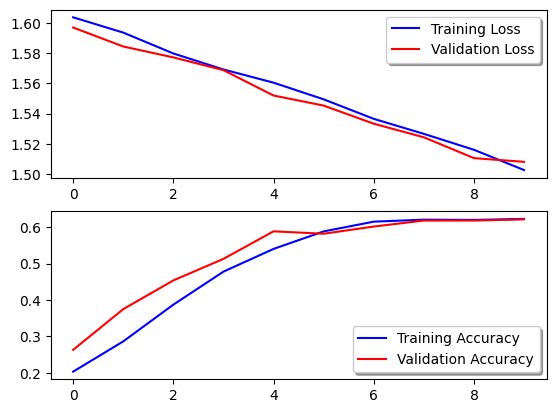

In [12]:
# plot the accuracy and loss values of training and validation with each epoch
fig, ax = plt.subplots(2,1)
ax[0].plot(logs['train_loss'], color='b', label="Training Loss")
ax[0].plot(logs['valid_losses'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(logs['train_acc'], color='b', label="Training Accuracy")
ax[1].plot(logs['valid_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

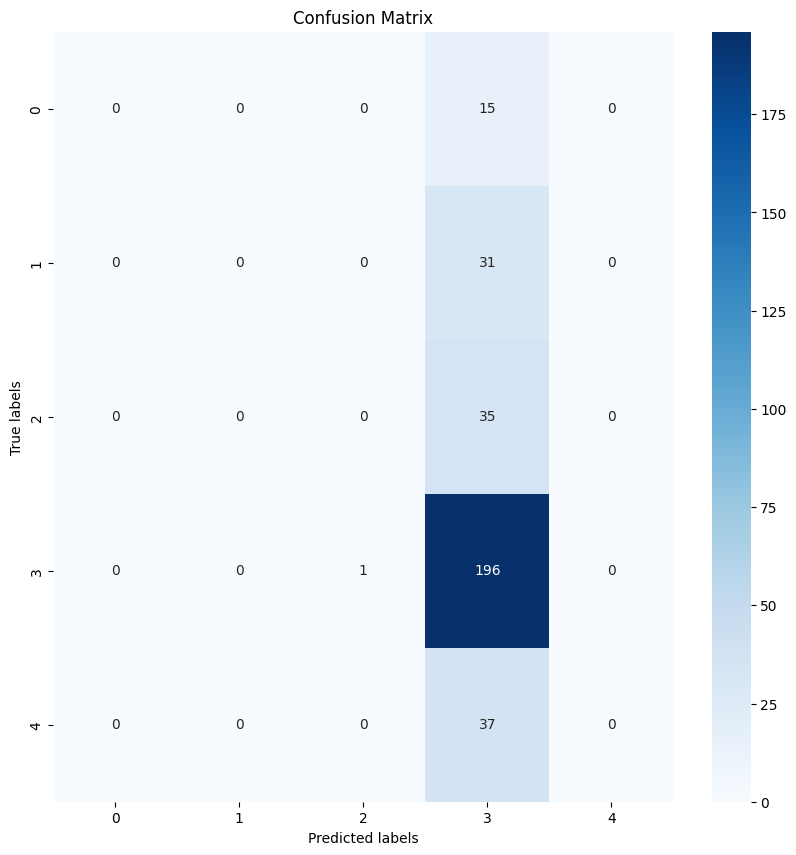

In [13]:
# 计算混淆矩阵
conf_mat = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 10))
# 使用Seaborn绘制混淆矩阵
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [14]:
# make performance metrics for each classes
accuracy = accuracy_score(all_targets, all_preds)
num_classes = 5
print(accuracy)

0.6222222222222222


d:\anaconda3\envs\amls2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\amls2\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


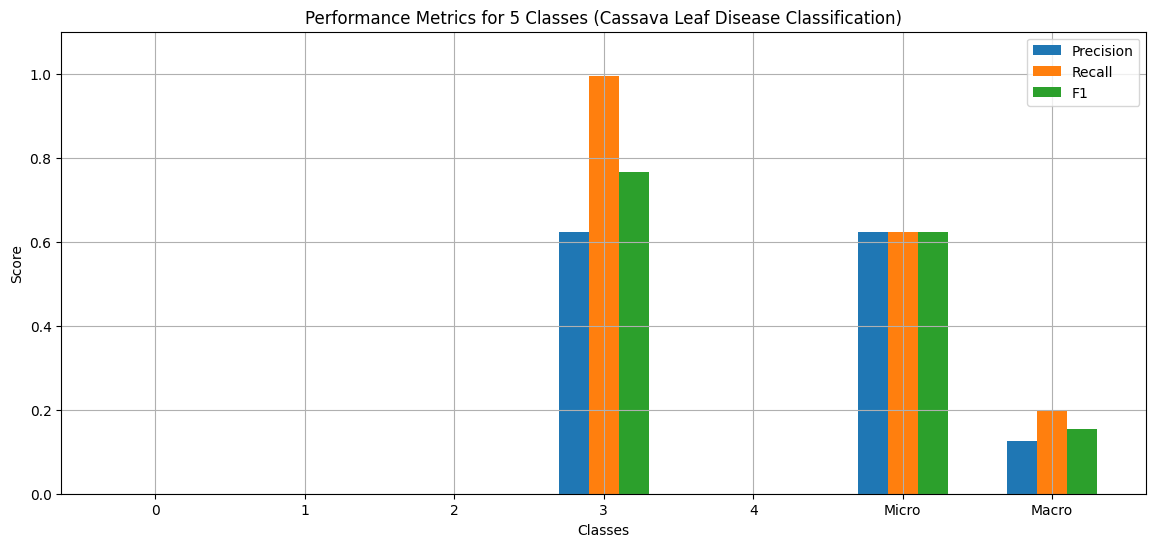

In [15]:
# define the values in normal, micro and macro state
precision = precision_score(all_targets, all_preds, average=None)
precision_micro = precision_score(all_targets, all_preds, average='micro')
precision_macro = precision_score(all_targets, all_preds, average='macro')

recall = recall_score(all_targets, all_preds, average=None)
recall_micro = recall_score(all_targets, all_preds, average='micro')
recall_macro = recall_score(all_targets, all_preds, average='macro')

f1 = f1_score(all_targets, all_preds, average=None)
f1_micro = f1_score(all_targets, all_preds, average='micro')
f1_macro= f1_score(all_targets, all_preds, average='macro')

precision = np.append(precision, [precision_micro, precision_macro])
recall = np.append(recall, [recall_micro, recall_macro])
f1 = np.append(f1, [f1_micro, f1_macro])
classes = list(range(num_classes)) + ['Micro', 'Macro']

x = np.arange(len(classes))
width = 0.2

fig1, ax1 = plt.subplots(figsize=(14, 6))
rects1 = ax1.bar(x - width, precision, width, label='Precision')
rects2 = ax1.bar(x, recall, width, label='Recall')
rects3 = ax1.bar(x + width, f1, width, label='F1')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics for 5 Classes (Cassava Leaf Disease Classification)')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.set_ylim(0, 1.1)
ax1.legend(loc='upper right')
ax1.grid(True)
plt.show()